In [ ]:
import pandas as pd
import numpy as np

def generate_synthetic_travel_data(num_rows=5000):
    """
    Generates a synthetic dataset for the Travel Recommendation System.
    The logic ensures a reasonable correlation between features and the target destination.
    """
    np.random.seed(42)

    #featre choices
    ages = np.random.randint(18, 65, num_rows)
    genders = np.random.choice(['Male', 'Female', 'Other'], num_rows, p=[0.45, 0.45, 0.1])
    incomes = np.random.choice(['Low', 'Medium', 'High'], num_rows, p=[0.3, 0.4, 0.3])
    companions = np.random.choice(['Solo', 'Family', 'Group'], num_rows, p=[0.35, 0.4, 0.25])
    activity_levels = np.random.randint(1, 6, num_rows)
    budgets = np.random.choice(['Economical', 'Mid-range', 'Luxury'], num_rows, p=[0.3, 0.4, 0.3])

    df = pd.DataFrame({
        'Age': ages,
        'Gender': genders,
        'Income_Level': incomes,
        'Travel_Companion': companions,
        'Activity_Level': activity_levels,
        'Budget': budgets,
    })

    #what does each destination signify
    def map_destination(row):
        #Adventure/Nature shows High activity, younger, solo/group, mid/low budget
        if (row['Activity_Level'] >= 4) and (row['Age'] < 40) and (row['Budget'] in ['Economical', 'Mid-range']):
            return 'Adventure/Nature'

        #Relaxation/Beach is Low activity, family/solo, high budget, older
        elif (row['Activity_Level'] <= 2) and (row['Budget'] in ['Luxury', 'Mid-range']):
            return 'Relaxation/Beach'

        #party/nightlife high activity and in 20s
        elif (row['Activity_Level'] >= 4) and (row['Age'] < 35):
            return 'Party/Nightlife'

        #Cultural/Historical is Mid activity, any companion, varied budget, slightly older on average
        elif (row['Activity_Level'] in [2, 3]) or (row['Age'] >= 45):
            return 'Cultural/Historical'

        #fallback
        return np.random.choice(['Adventure/Nature', 'Relaxation/Beach', 'Cultural/Historical', 'Party/Nightlife'])

    df['Target_Destination'] = df.apply(map_destination, axis=1)

    #to add some noise/overlap
    num_noise = int(num_rows * 0.05)
    noise_indices = np.random.choice(df.index, num_noise, replace=False)

    destination_options = ['Adventure/Nature', 'Relaxation/Beach', 'Cultural/Historical', 'Party/Nightlife']

    for i in noise_indices:
        current_dest = df.loc[i, 'Target_Destination']
        #any destination that goes against the real/target one
        new_dest = np.random.choice([d for d in destination_options if d != current_dest])
        df.loc[i, 'Target_Destination'] = new_dest

    return df


data_df = generate_synthetic_travel_data(num_rows=5000)
data_df.to_csv('travel_data.csv', index=False)

print("Successfully created 'travel_data.csv' with 5000 rows.")
print("You can now proceed with the analysis notebook (ml_mini_project.ipynb).")


Successfully created 'travel_data.csv' with 5000 rows.
You can now proceed with the analysis notebook (ml_mini_project.ipynb).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.pipeline import Pipeline
from joblib import dump, load


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb
import shap #(calcs har feature ka cotribution)


try:
    df = pd.read_csv('/content/travel_data.csv')
except FileNotFoundError:
    print("Please ensure 'travel_data.csv' is in the current directory.")

    data = {
        'Age': [30, 45, 22], 'Gender': ['Male', 'Female', 'Other'],
        'Income_Level': ['Medium', 'High', 'Low'], 'Travel_Companion': ['Solo', 'Family', 'Group'],
        'Activity_Level': [5, 2, 4], 'Budget': ['Mid-range', 'Luxury', 'Economical'],
        'Target_Destination': ['Adventure/Nature', 'Relaxation/Beach', 'Party/Nightlife']
    }
    df = pd.DataFrame(data)
#try and except exception handling jst in case , creates a dummy dataset
print("Data Loaded. First 5 rows:")
print(df.head())
print("\nData Info:")
print(df.info())


Data Loaded. First 5 rows:
   Age  Gender Income_Level Travel_Companion  Activity_Level     Budget  \
0   56  Female          Low             Solo               2  Mid-range   
1   46   Other       Medium            Group               4     Luxury   
2   32  Female          Low             Solo               2  Mid-range   
3   60    Male         High           Family               3  Mid-range   
4   25  Female         High           Family               4  Mid-range   

    Target_Destination  
0     Relaxation/Beach  
1  Cultural/Historical  
2     Relaxation/Beach  
3  Cultural/Historical  
4     Adventure/Nature  

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Age                 5000 non-null   int64 
 1   Gender              5000 non-null   object
 2   Income_Level        5000 non-null   object
 3   Travel_Co

In [ ]:
print(f"\nMissing values check:\n{df.isnull().sum()}")


Missing values check:
Age                   0
Gender                0
Income_Level          0
Travel_Companion      0
Activity_Level        0
Budget                0
Target_Destination    0
dtype: int64


/tmp/ipython-input-3953874624.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='Target_Destination', data=df, palette='viridis')
/tmp/ipython-input-3953874624.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Target_Destination', y='Age', data=df, palette='Set3')


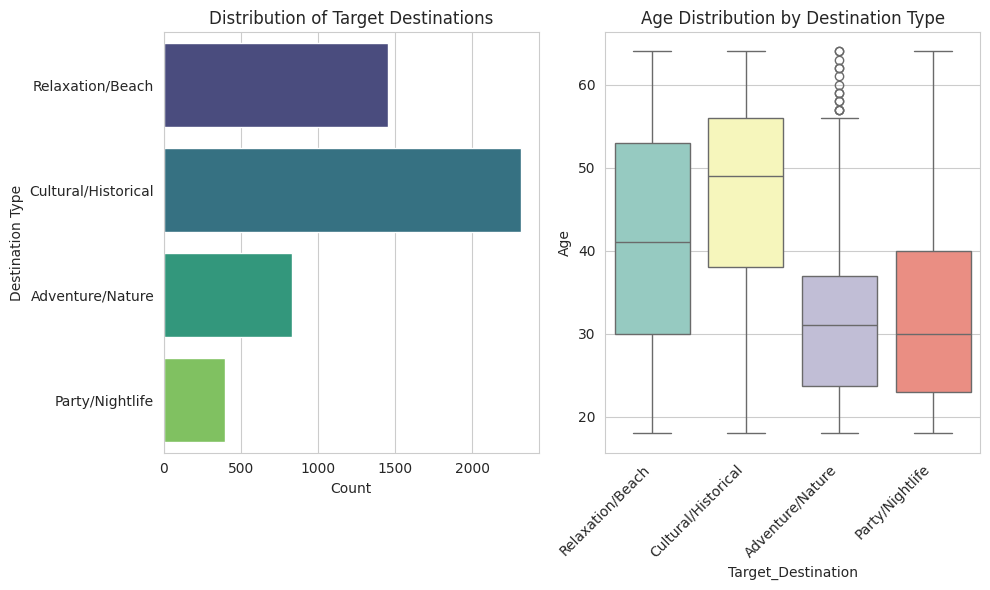

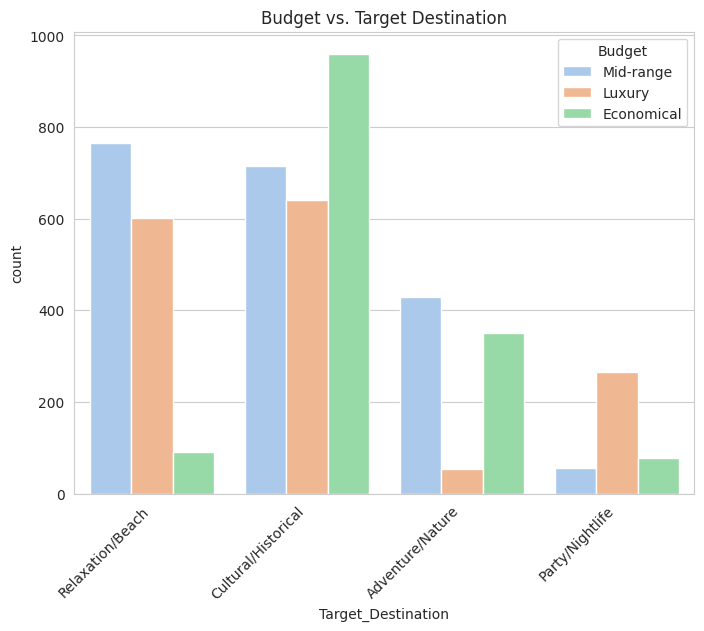

In [ ]:
# performing basic EDA like plotting graphs and analysis and encoding
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))


plt.subplot(1, 2, 1)
sns.countplot(y='Target_Destination', data=df, palette='viridis')
plt.title('Distribution of Target Destinations')
plt.xlabel('Count')
plt.ylabel('Destination Type')
#even class distribtion


#age vs dest
plt.subplot(1, 2, 2)
sns.boxplot(x='Target_Destination', y='Age', data=df, palette='Set3')
plt.title('Age Distribution by Destination Type')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#bdget vs dest
plt.figure(figsize=(8, 6))
sns.countplot(x='Target_Destination', hue='Budget', data=df, palette='pastel')
plt.title('Budget vs. Target Destination')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Budget')
plt.show()

In [ ]:
#encoding
le = LabelEncoder()
df['Destination_Encoded'] = le.fit_transform(df['Target_Destination'])
X = df.drop(['Target_Destination', 'Destination_Encoded'], axis=1)
y = df['Destination_Encoded']
X_encoded = pd.get_dummies(X, columns=['Gender', 'Income_Level', 'Travel_Companion', 'Budget'], drop_first=True)


numerical_features = ['Age', 'Activity_Level']
#featre scaliing
scaler = StandardScaler()
X_encoded[numerical_features] = scaler.fit_transform(X_encoded[numerical_features])

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)
print(f"Shape of Training Data (X): {X_train.shape}")
print(f"Features used for modeling: {X_train.columns.tolist()}")

Shape of Training Data (X): (4000, 10)
Features used for modeling: ['Age', 'Activity_Level', 'Gender_Male', 'Gender_Other', 'Income_Level_Low', 'Income_Level_Medium', 'Travel_Companion_Group', 'Travel_Companion_Solo', 'Budget_Luxury', 'Budget_Mid-range']


In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machine (SVM)": SVC(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

results = {}

print("\nTraining All Base Models")
print(f"| {'Model':<25} | Train Acc. | Train F1   |  Acc.  | F1    |")


for name, model in models.items():
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred, average='weighted')
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')

    results[name] = {
        'Train Accuracy': train_accuracy,
        'Train F1-Score': train_f1,
        'Accuracy': test_accuracy,
        'F1-Score': test_f1
    }

    print(f"| {name:<25} | {train_accuracy:10.4f} | {train_f1:10.4f} | {test_accuracy:10.4f} | {test_f1:10.4f} |")





Training All Base Models
| Model                     | Train Acc. | Train F1   |  Acc.  | F1    |
| Logistic Regression       |     0.8335 |     0.8304 |     0.8350 |     0.8313 |
| Decision Tree             |     0.9868 |     0.9867 |     0.8430 |     0.8422 |
| K-Nearest Neighbors       |     0.8958 |     0.8934 |     0.8620 |     0.8592 |
| Support Vector Machine (SVM) |     0.8945 |     0.8911 |     0.8870 |     0.8830 |
| Random Forest             |     0.9868 |     0.9867 |     0.8720 |     0.8699 |
| AdaBoost                  |     0.8363 |     0.8354 |     0.8420 |     0.8402 |
| Gradient Boosting         |     0.9048 |     0.9026 |     0.8900 |     0.8872 |


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [08:12:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| XGBoost                   |     0.9665 |     0.9664 |     0.8800 |     0.8787 |


In [ ]:
rf_pipe = Pipeline([
    #hyperparameter tning for decision tree to maximse metrics
    ('scaler', StandardScaler()),
    ('randomforestclassifier', RandomForestClassifier(random_state=42))
])

rf_param_grid = {
    'randomforestclassifier__n_estimators': [100, 200, 300],
    'randomforestclassifier__max_depth': [5, 10, 15],
    'randomforestclassifier__min_samples_split': [2, 5],
}
#gridserachCV with aramgrid , 5 fold validation
rf_grid_search = GridSearchCV(
    rf_pipe,
    rf_param_grid,
    cv=5,
    scoring='f1_weighted',
)

rf_grid_search.fit(X_train, y_train)
best_rf_model = rf_grid_search.best_estimator_
y_pred_tuned = best_rf_model.predict(X_test)
f1_tuned = f1_score(y_test, y_pred_tuned, average='weighted')
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
print("Results of Tuned Random Forest Model")
print(f"Best Parameters Found: {rf_grid_search.best_params_}")
print(f"| Tuned Random Forest is  Accuracy: {accuracy_tuned:.4f} | F1-Score: {f1_tuned:.4f} |")
results['Tuned Random Forest'] = {'Accuracy': accuracy_tuned, 'F1-Score': f1_tuned}


Results of Tuned Random Forest Model
Best Parameters Found: {'randomforestclassifier__max_depth': 5, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 100}
| Tuned Random Forest is  Accuracy: 0.8870 | F1-Score: 0.8838 |


Feature Importance (PFI)
 Permutation Feature Importance (PFI)
Features ranked by impact on F1-Score when shuffled:
                  Feature  Importance_Mean  Importance_Std
1          Activity_Level         0.409035        0.011479
0                     Age         0.167312        0.008338
8           Budget_Luxury         0.156391        0.005529
9        Budget_Mid-range         0.133472        0.011566
5     Income_Level_Medium         0.000288        0.000816
3            Gender_Other         0.000117        0.000743
7   Travel_Companion_Solo        -0.000236        0.000696
4        Income_Level_Low        -0.000329        0.000586
6  Travel_Companion_Group        -0.000771        0.000592
2             Gender_Male        -0.001258        0.001732


/tmp/ipython-input-2968056794.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance_Mean', y='Feature', data=pfi_df.head(10), palette='plasma')


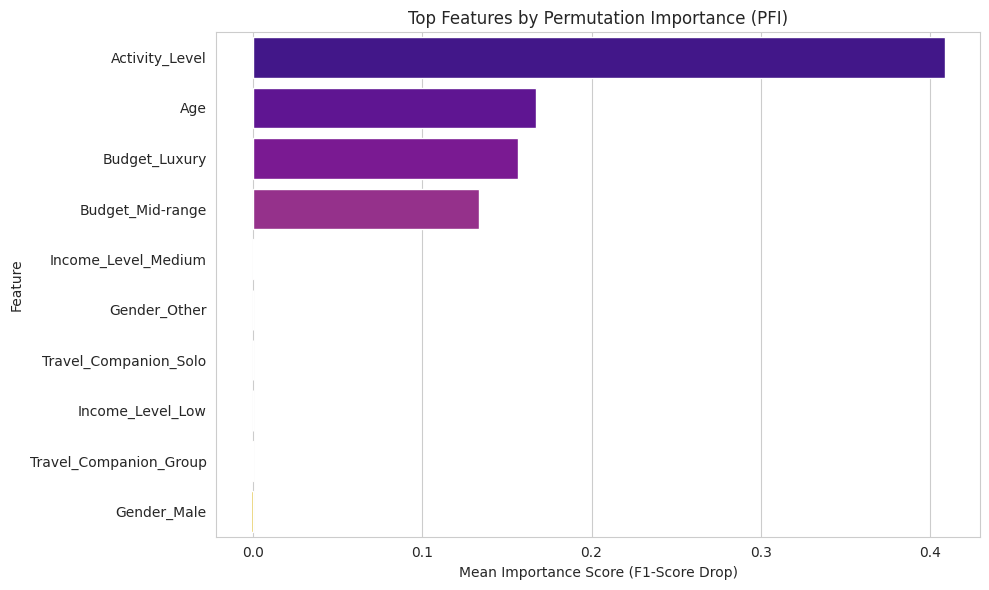

In [ ]:
print("Feature Importance (PFI)")
#pfi measres how the perfoc=mance changes as featre is shuffled calculating how mch each feature acconts for / contibutes

from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_curve, auc
FINAL_MODEL = best_rf_model
perm_importance = permutation_importance(FINAL_MODEL, X_test, y_test,
                                         n_repeats=10, random_state=42,
                                         scoring='f1_weighted', n_jobs=-1)
pfi_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance_Mean': perm_importance.importances_mean,
    'Importance_Std': perm_importance.importances_std
}).sort_values(by='Importance_Mean', ascending=False)

print(" Permutation Feature Importance (PFI)")
print("Features ranked by impact on F1-Score when shuffled:")
print(pfi_df.head(10))

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance_Mean', y='Feature', data=pfi_df.head(10), palette='plasma')
plt.title('Top Features by Permutation Importance (PFI)')
plt.xlabel('Mean Importance Score (F1-Score Drop)')
plt.tight_layout()
plt.show()


In [ ]:
df_results = pd.DataFrame(results).T.sort_values(by='F1-Score', ascending=True)
print("\n Final Comparative Model Analysis")
print(df_results)



 Final Comparative Model Analysis
                              Accuracy  F1-Score
Logistic Regression              0.835  0.831274
AdaBoost                         0.842  0.840170
Decision Tree                    0.843  0.842219
K-Nearest Neighbors              0.862  0.859197
Random Forest                    0.872  0.869880
XGBoost                          0.880  0.878674
Support Vector Machine (SVM)     0.887  0.882976
Tuned Random Forest              0.887  0.883801
Gradient Boosting                0.890  0.887236


In [ ]:
dump(FINAL_MODEL, 'best_rf_model.joblib')
dump(scaler, 'scaler.joblib')
#saves featre in exact same order
X_cols = X_train.columns.tolist()
dump(X_cols, 'feature_columns.joblib')
dump(le, 'label_encoder.joblib')
print("Ready for Deployment!")


Ready for Deployment!


In [ ]:
!pip install gradio

In [ ]:
import gradio as gr
import pandas as pd
import numpy as np
from joblib import load
import os

# Load model assets
try:
    model = load('best_rf_model.joblib')
    scaler = load('scaler.joblib')
    feature_columns = load('feature_columns.joblib')
    label_encoder = load('label_encoder.joblib')
except FileNotFoundError:
    print("FATAL ERROR: Model assets not found!")
    print("Ensure all .joblib files are in the current working directory.")
    exit()

# Prediction function
def predict_destination(age, gender, income_level, travel_companion, activity_level, budget):
    input_data = pd.DataFrame({
        'Age': [age],
        'Activity_Level': [activity_level],
        'Gender': [gender],
        'Income_Level': [income_level],
        'Travel_Companion': [travel_companion],
        'Budget': [budget]
    })

    numerical_features = ['Age', 'Activity_Level']
    input_encoded = pd.get_dummies(
        input_data,
        columns=['Gender', 'Income_Level', 'Travel_Companion', 'Budget'],
        drop_first=True
    )

    input_encoded[numerical_features] = scaler.transform(input_encoded[numerical_features])
    final_input = pd.DataFrame(0, index=[0], columns=feature_columns)
    for col in input_encoded.columns:
        if col in final_input.columns:
            final_input[col] = input_encoded[col].iloc[0]

    try:
        prediction_encoded = model.predict(final_input)[0]
        prediction_label = label_encoder.inverse_transform([prediction_encoded])[0]
        probabilities = model.predict_proba(final_input)[0]
        confidence = probabilities[prediction_encoded] * 100

        emoji_map = {
            "Adventure/Nature": "🏔️ Adventure/Nature",
            "Relaxation/Beach": "🏖️ Relaxation/Beach",
            "Cultural/Historical": "🏛️ Cultural/Historical",
            "Party/Nightlife": "🎉 Party/Nightlife"
        }

        # Animated output box ✨
        result_text = f"""
        <div style='
            animation: fadeSlideIn 1s ease-out;
            background-color: #fff4e6;
            padding: 25px;
            border-radius: 14px;
            border-left: 6px solid #d97706;
            box-shadow: 0 4px 12px rgba(165, 88, 28, 0.25);
        '>
            <h3 style='font-family: Helvetica, sans-serif; color: #b45309;'>Recommended Destination:</h3>
            <h1 style='font-family: Helvetica, sans-serif; color: #92400e;'>{emoji_map.get(prediction_label, '🌍 Unknown')}</h1>
            <p style='font-size: 18px; font-family: Helvetica, sans-serif;'>Model Confidence: <strong>{confidence:.2f}%</strong></p>
        </div>
        """
        return result_text

    except Exception as e:
        return f"<p style='color: red;'>Prediction Error: {e}</p>"

# Inputs
age_slider = gr.Slider(minimum=18, maximum=75, value=30, label="1. Age")
activity_slider = gr.Slider(minimum=1, maximum=5, step=1, value=4, label="2. Preferred Activity Level (1=Relaxing, 5=Intense)")
gender_dropdown = gr.Dropdown(choices=["Male", "Female", "Other"], label="3. Gender", value="Male")
income_dropdown = gr.Dropdown(choices=["Low", "Medium", "High"], label="4. Income Level", value="Medium")
companion_dropdown = gr.Dropdown(choices=["Solo", "Family", "Group"], label="5. Travel Companion", value="Solo")
budget_dropdown = gr.Dropdown(choices=["Economical", "Mid-range", "Luxury"], label="6. Budget", value="Mid-range")

inputs = [
    age_slider,
    gender_dropdown,
    income_dropdown,
    companion_dropdown,
    activity_slider,
    budget_dropdown
]

# Custom Title & Subtitle
custom_title = """
<div style='
    text-align: center;
    font-family: Helvetica, sans-serif;
    color: #b45309;
    font-size: 42px;
    font-weight: bold;
    letter-spacing: 1px;
    margin-bottom: 6px;
'>
    Personalized Travel Destination Recommender
</div>
<div style='
    text-align: center;
    font-family: Helvetica, sans-serif;
    color: #92400e;
    font-size: 16px;
    font-style: italic;
    text-decoration: underline;
    margin-bottom: 25px;
'>
    Powered by Tuned Random Forest Classifier
</div>
"""

custom_description = """
<div style='
    background-color: #fef6e4;
    padding: 20px;
    border-radius: 12px;
    box-shadow: 0px 3px 10px rgba(120, 66, 18, 0.15);
    font-family: Helvetica, sans-serif;
    font-size: 17px;
    color: #3f2e1e;
    line-height: 1.6;
'>
    <p>✨ Tell us a bit about your preferences and we'll match you with the perfect travel vibe — <b>Adventure</b>, <b>Relaxation</b>, <b>Cultural</b>, or <b>Party</b>!</p>
</div>
"""

# Interface setup
iface = gr.Interface(
    fn=predict_destination,
    inputs=inputs,
    outputs=gr.HTML(label="Destination Recommendation"),
    title=custom_title,
    description=custom_description,
    live=False,
    allow_flagging='never'
)

# Aesthetic theme + animation CSS
iface.css = """
@keyframes fadeSlideIn {
    from {
        opacity: 0;
        transform: translateY(20px);
    }
    to {
        opacity: 1;
        transform: translateY(0);
    }
}

body {
    background-color: #fdf6ec !important;
    font-family: Helvetica, sans-serif !important;
}

.gradio-container {
    background: linear-gradient(180deg, #fdf6ec 0%, #fffaf3 100%);
    border-radius: 20px;
    padding: 20px !important;
}

label, .gradio-input label, .gradio-output label {
    color: #7c3e11 !important;
    font-weight: 600 !important;
}

input, select, textarea, .gradio-slider input {
    background-color: #fffaf2 !important;
    border: 1.5px solid #eab308 !important;
    color: #5b3410 !important;
    border-radius: 10px !important;
    box-shadow: 0 3px 6px rgba(160, 82, 45, 0.15) !important;
}

button {
    background-color: #d97706 !important;
    color: #fff !important;
    font-family: Helvetica, sans-serif !important;
    border-radius: 10px !important;
    font-size: 16px !important;
    font-weight: bold !important;
    box-shadow: 0 4px 10px rgba(139, 69, 19, 0.25) !important;
    transition: all 0.25s ease-in-out !important;
}

button:hover {
    background-color: #b45309 !important;
    transform: scale(1.05);
}
"""

# Launch
if __name__ == "__main__":
    iface.launch(inline=True, share=True)



/usr/local/lib/python3.12/dist-packages/gradio/interface.py:415: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated. Use `flagging_mode` instead.
  warnings.warn(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://2fecf66cf6daa6a9c9.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
